# Experiment-2: Logistic Regression and SVM
## In this experiment, we will: 
- (1) Get more intuitions about Logistic Regression and SVM. 
- (2) Get your hands dirty on [a9a dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#a9a), which is one of the [LIBSVM Dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/).
- (3) Get some experience about hyper-parameter tuning, loss function selection in SVM, optimizer selection, initializer selection.
### As usual, in this experiment, we will use the mini framework [simple_ml](https://github.com/lizhaoliu-Lec/simple_ml), which means simple machine learning, written by [lizhaoliu-Lec](https://github.com/lizhaoliu-Lec/).

In [1]:
# as usual, do a little setup
%pip install simple_machine_learning
import numpy as np
from pprint import pprint

from sklearn.datasets import load_svmlight_file

from simple_ml.preprocessing.general import Standardizer
from simple_ml.nn.layer import Input, Linear
from simple_ml.nn.model import Model
from simple_ml.nn.initializer import zeros, ones, xavier_uniform_initializer, default_weight_initializer
from simple_ml.nn.regularizer import L2_Regularizer, L1_Regularizer, L1L2_Regularizer
from simple_ml.nn.optimizer import SGD, Momentum, Adam, RMSProp
from simple_ml.utils.metric import accuracy, absolute_error

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load the (preprocessed) a9a data.
# fix random seed
np.random.seed(1234)

# some utils func
def convert_to_onehot(x):
    return np.array(x == 1, dtype=np.float)

# read the data
def get_a9a_data(data_path='../tmp/exp2/a9a'):
    X_train, y_train = load_svmlight_file(data_path)
    X_test, y_test = load_svmlight_file(data_path + '.t', n_features=123)
    X_train, X_test = X_train.A, X_test.A
    y_train, y_test = np.reshape(y_train, (-1, 1)), np.reshape(y_test, (-1, 1))

    return X_train, X_test, y_train, y_test
    

X_train, X_test, y_train, y_test = get_a9a_data()
print('We have `%d` training examples and `%d` test examples' % (X_train.shape[0], X_test.shape[0]))
print('X_train shape: ', X_train.shape, ', X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape, ', y_test shape: ', y_test.shape)
print('But we set aside 20% of the training examples for validation.\n')
val_split = 0.2
val_size = int(X_train.shape[0] * val_split)
X_val, y_val, X_train, y_train = X_train[:val_size], y_train[:val_size], X_train[val_size:], y_train[val_size:]
y_train_one_hot = convert_to_onehot(y_train)
y_val_one_hot = convert_to_onehot(y_val)
y_test_one_hot = convert_to_onehot(y_test)
print('Finally, we have...')
print('We have `%d` training examples, `%d` validation examples and `%d` test examples' % (X_train.shape[0], X_val.shape[0],X_test.shape[0]))
print('X_train shape: ', X_train.shape, ', X_val shape: ', X_val.shape, ', X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape, ', y_val shape: ', y_val.shape, ', y_test shape: ', y_test.shape)

We have `32561` training examples and `16281` test examples
X_train shape:  (32561, 123) , X_test shape:  (16281, 123)
y_train shape:  (32561, 1) , y_test shape:  (16281, 1)
But we set aside 20% of the training examples for validation.

Finally, we have...
We have `26049` training examples, `6512` validation examples and `16281` test examples
X_train shape:  (26049, 123) , X_val shape:  (6512, 123) , X_test shape:  (16281, 123)
y_train shape:  (26049, 1) , y_val shape:  (6512, 1) , y_test shape:  (16281, 1)


## Normalized the data:
As usual, we normalize the data.

In [19]:
# print('Before normalized the data...')
# print('*** X_train *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_train, axis=0), np.var(X_train, axis=0)))
# print('*** X_val *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_val, axis=0), np.var(X_val, axis=0)))
# print('*** X_test *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_test, axis=0), np.var(X_test, axis=0)))
standardizer = Standardizer()
standardizer.fit(X_train)
X_train = standardizer.transform(X_train)
X_val = standardizer.transform(X_val)
X_test = standardizer.transform(X_test)

# print('\nAfter normalized the data...')
# print('*** X_train *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_train, axis=0), np.var(X_train, axis=0)))
# print('*** X_val *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_val, axis=0), np.var(X_val, axis=0)))
# print('*** X_test *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_test, axis=0), np.var(X_test, axis=0)))

## Tuning Hyper-parameter C in SVM
As usual, we normalize the data.

In [6]:
# we build svm using simple_ml frame work.
def svm(C=1, loss_fn='HL'):
    Inputs = Input(input_shape=X_train.shape[1])
    Out = Linear(output_dim=1,
               regularizer=L2_Regularizer(1 / C),
                initializer=zeros,
               activation=None)(Inputs)
    model = Model(Inputs, Out)
    # set to hinge loss
    model.set_loss(loss_fn)
    return model, Out

We first search it in a coarse-grained range $log_{10}^{C} \in [-2, -1, 0, 1, 2, 3, 4]$.


********** begin C = 0.01 **********

epoch   100/  200, train-[loss: 1.8425 | metric: 0.7644]; valid-[loss: 1.8494 | metric: 0.7646]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[-1], predict-[-1]
valid-example 3/5: expect-[-1], predict-[-1]
valid-example 4/5: expect-[1], predict-[-1]
valid-example 5/5: expect-[-1], predict-[-1]

epoch   200/  200, train-[loss: 1.7548 | metric: 0.7657]; valid-[loss: 1.7598 | metric: 0.7629]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[-1], predict-[-1]
valid-example 3/5: expect-[-1], predict-[-1]
valid-example 4/5: expect-[-1], predict-[-1]
valid-example 5/5: expect-[-1], predict-[-1]
{'train_set': {'best_epoch': 3,
               'best_loss': 4.133965759916972,
               'best_metric': 0.8344658144266575},
 'val_set': {'best_epoch': 2,
             'best_loss': 3.714120720176422,
             'best_metric': 0.828470515970516}}
********** end C = 0.01 **********

********** begin C = 0.1 *

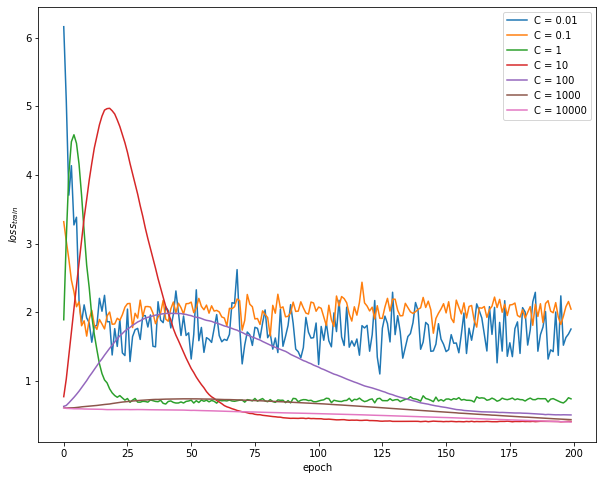

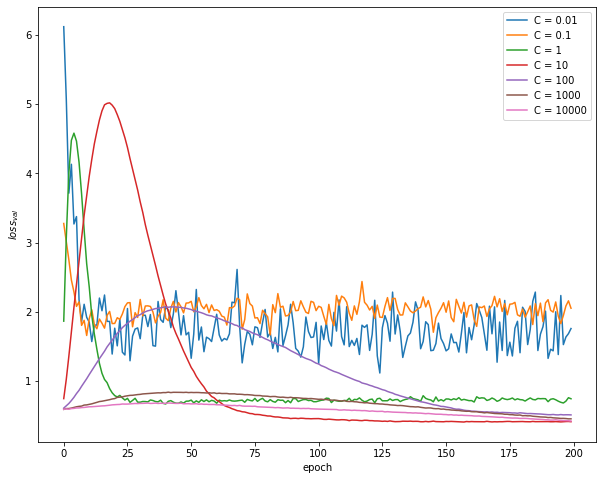

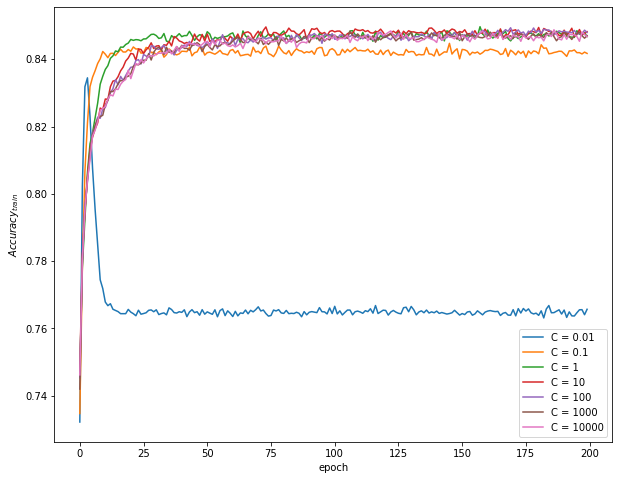

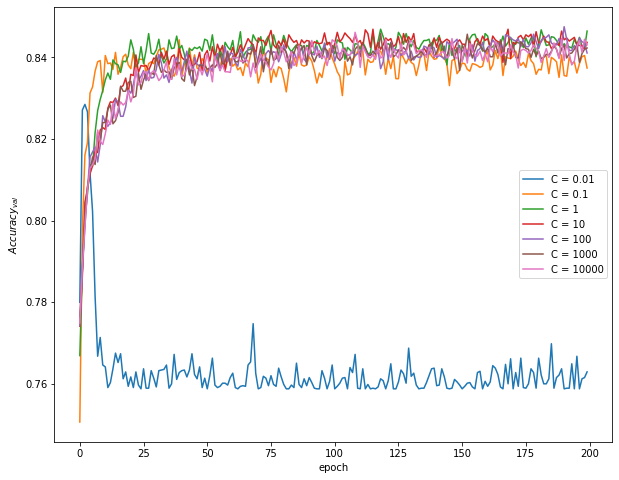

No handles with labels found to put in legend.


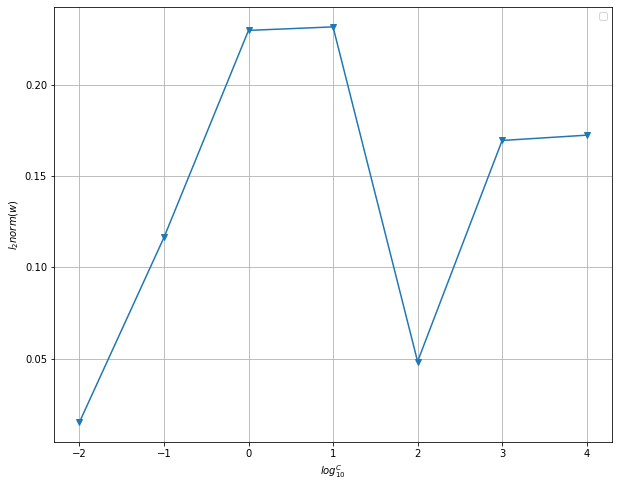

In [7]:
Cs = [0.01, 0.1, 1, 10, 100, 1000, 10000]
Cmagnitude = [-2, -1, 0, 1, 2, 3, 4]
c2train_errors = []
c2val_errors = []
c2train_acc = []
c2val_acc = []
c2magnitude = []

for C in Cs:
    print()
    print(10 * '*' + ' begin C = %s ' % str(C) + 10 * '*')
    SVM, Out = svm(C=C)
    SVM.set_optimizer(SGD(lr=0.001))
    SVM.fit(X_train, y_train,
            verbose=100, epochs=200,
            validation_data=(X_val, y_val),
            batch_size=64, metric='svm_binary_accuracy',
            shuffle=True,
            peek_type='single-svm-cls')
    pprint(SVM.best_performance())
    print(10 * '*' + ' end C = %s ' % str(C) + 10 * '*')
    c2train_errors.append(SVM.training_losses)
    c2val_errors.append(SVM.valid_losses)
    c2train_acc.append(SVM.train_metrics)
    c2val_acc.append(SVM.validation_metrics)
    c2magnitude.append(np.linalg.norm(Out.weight.T, ord=2, axis=1)[0])

for idx, c in enumerate(Cs):
    plt.plot(c2train_errors[idx], label='C = %s' % str(c))
plt.xlabel('epoch')
plt.ylabel('$loss_{train}$')
plt.legend()
# plt.savefig('c_train_loss.png', dpi=300)
plt.show()

for idx, c in enumerate(Cs):
    plt.plot(c2val_errors[idx], label='C = %s' % str(c))
plt.xlabel('epoch')
plt.ylabel('$loss_{val}$')
plt.legend()
# plt.savefig('c_val_loss.png', dpi=300)
plt.show()

for idx, c in enumerate(Cs):
    plt.plot(c2train_acc[idx], label='C = %s' % str(c))
plt.xlabel('epoch')
plt.ylabel('$Accuracy_{train}$')
plt.legend()
# plt.savefig('c_train_acc.png', dpi=300)
plt.show()

for idx, c in enumerate(Cs):
    plt.plot(c2val_acc[idx], label='C = %s' % str(c))
plt.xlabel('epoch')
plt.ylabel('$Accuracy_{val}$')
plt.legend()
# plt.savefig('c_val_acc.png', dpi=300)
plt.show()

plt.plot(Cmagnitude, c2magnitude, marker='v')
plt.xlabel('$log_{10}^C$')
plt.ylabel('$l_2norm(w)$')
plt.grid()
plt.legend()
# plt.savefig('c_magnitude.png', dpi=300)
plt.show()

Then search it in a fine-grained range $C \in range(1， 11)$.



********** begin C = 1 **********

epoch   100/  200, train-[loss: 0.6926 | metric: 0.8472]; valid-[loss: 0.6999 | metric: 0.8421]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[-1], predict-[-1]
valid-example 3/5: expect-[1], predict-[-1]
valid-example 4/5: expect-[-1], predict-[-1]
valid-example 5/5: expect-[-1], predict-[-1]

epoch   200/  200, train-[loss: 0.7404 | metric: 0.8459]; valid-[loss: 0.7464 | metric: 0.8451]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[-1], predict-[-1]
valid-example 3/5: expect-[-1], predict-[-1]
valid-example 4/5: expect-[-1], predict-[-1]
valid-example 5/5: expect-[1], predict-[1]

********** begin C = 2 **********

epoch   100/  200, train-[loss: 0.5791 | metric: 0.8475]; valid-[loss: 0.5879 | metric: 0.8429]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[-1], predict-[1]
valid-example 3/5: expect-[-1], predict-[-1]
valid-example 4/5: expect-[-1], predict-[-1]
valid-e

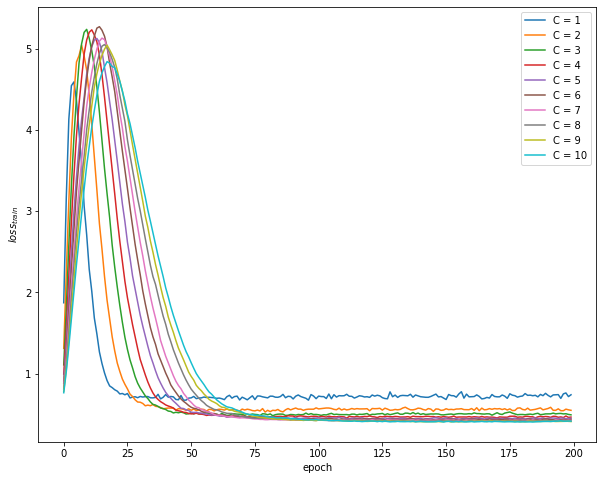

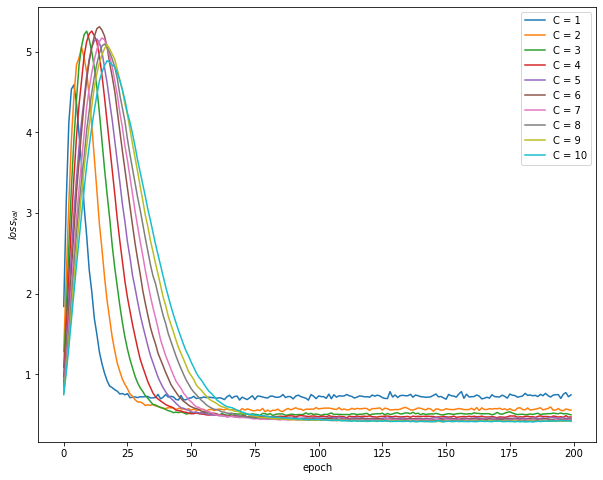

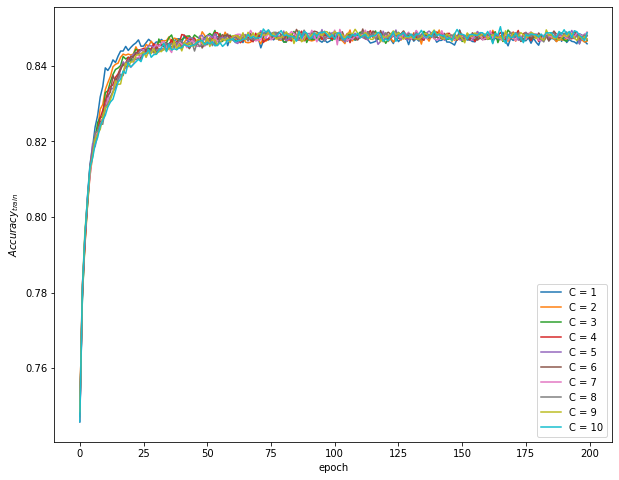

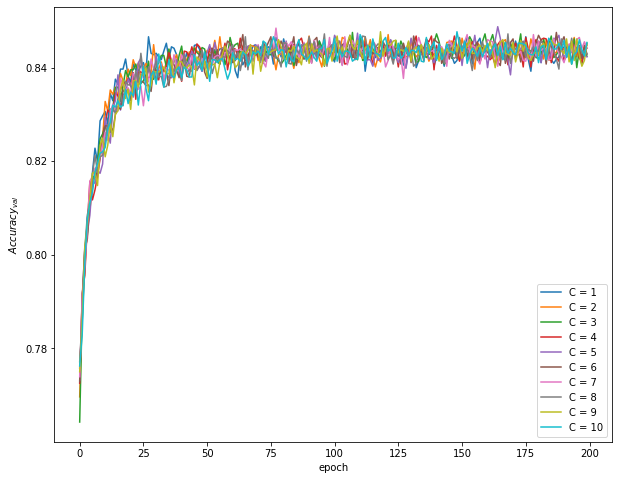

In [8]:
Cs = range(1, 11)
c2train_errors = []
c2val_errors = []
c2train_acc = []
c2val_acc = []

for C in Cs:
    print()
    print(10 * '*' + ' begin C = %s ' % str(C) + 10 * '*')
    SVM, Out = svm(C=C)
    SVM.set_optimizer(SGD(lr=0.001))
    SVM.fit(X_train, y_train,
            verbose=100, epochs=200,
            validation_data=(X_val, y_val),
            batch_size=64, metric='svm_binary_accuracy',
            shuffle=True,
            peek_type='single-svm-cls')
    c2train_errors.append(SVM.training_losses)
    c2val_errors.append(SVM.valid_losses)
    c2train_acc.append(SVM.train_metrics)
    c2val_acc.append(SVM.validation_metrics)

for idx, c in enumerate(Cs):
    plt.plot(c2train_errors[idx], label='C = %s' % str(c))
plt.xlabel('epoch')
plt.ylabel('$loss_{train}$')
plt.legend()
# plt.savefig('fine_c_train_loss.png', dpi=300)
plt.show()

for idx, c in enumerate(Cs):
    plt.plot(c2val_errors[idx], label='C = %s' % str(c))
plt.xlabel('epoch')
plt.ylabel('$loss_{val}$')
plt.legend()
# plt.savefig('fine_c_val_loss.png', dpi=300)
plt.show()

for idx, c in enumerate(Cs):
    plt.plot(c2train_acc[idx], label='C = %s' % str(c))
plt.xlabel('epoch')
plt.ylabel('$Accuracy_{train}$')
plt.legend()
# plt.savefig('fine_c_train_acc.png', dpi=300)
plt.show()

for idx, c in enumerate(Cs):
    plt.plot(c2val_acc[idx], label='C = %s' % str(c))
plt.xlabel('epoch')
plt.ylabel('$Accuracy_{val}$')
plt.legend()
# plt.savefig('fine_c_val_acc.png', dpi=300)
plt.show()

## Loss function comparision in SVM.
First we plot Hinge Loss(HL) and Exponential Loss(EL). 

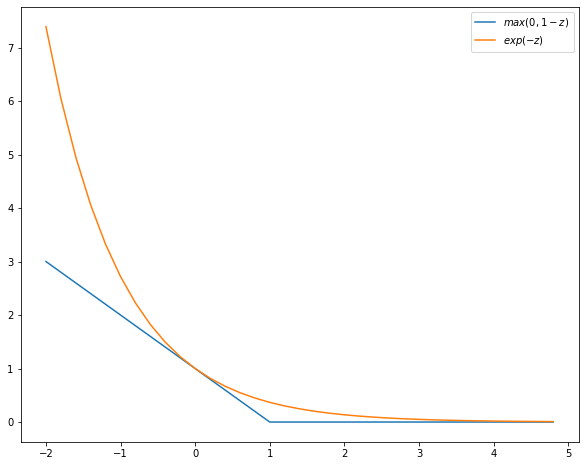

In [9]:
def hl_forward(z):
    return np.maximum(0, 1 - z)

def el_forward(z):
    return np.exp(-1 * z)

z = np.arange(-2, 5, 0.2)
hl_z = hl_forward(z)
el_z = el_forward(z)
plt.plot(z, hl_z, label= '$max(0, 1 - z)$')
plt.plot(z, el_z, label= '$exp(-z)$')
plt.legend()
# plt.savefig('loss_fn.png', dpi=300)
plt.show()

Now we explore the difference between HL and EL in terms of performance.


********** begin L = HL **********

epoch   100/  200, train-[loss: 0.4185 | metric: 0.8475]; valid-[loss: 0.4259 | metric: 0.8424]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[1], predict-[-1]
valid-example 3/5: expect-[-1], predict-[1]
valid-example 4/5: expect-[-1], predict-[-1]
valid-example 5/5: expect-[-1], predict-[1]

epoch   200/  200, train-[loss: 0.4078 | metric: 0.8472]; valid-[loss: 0.4143 | metric: 0.8434]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[-1], predict-[-1]
valid-example 3/5: expect-[1], predict-[-1]
valid-example 4/5: expect-[1], predict-[-1]
valid-example 5/5: expect-[-1], predict-[1]

********** begin L = EL **********

epoch   100/  200, train-[loss: 41.2490 | metric: 0.8084]; valid-[loss: 41.2478 | metric: 0.8127]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[-1], predict-[-1]
valid-example 3/5: expect-[-1], predict-[1]
valid-example 4/5: expect-[1], predict-[-1]
valid-e

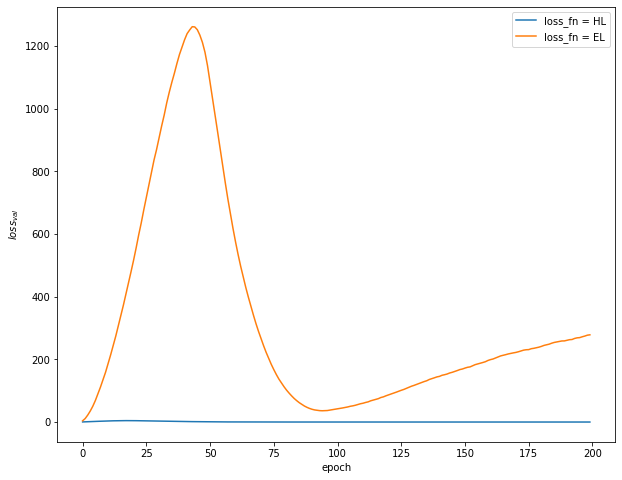

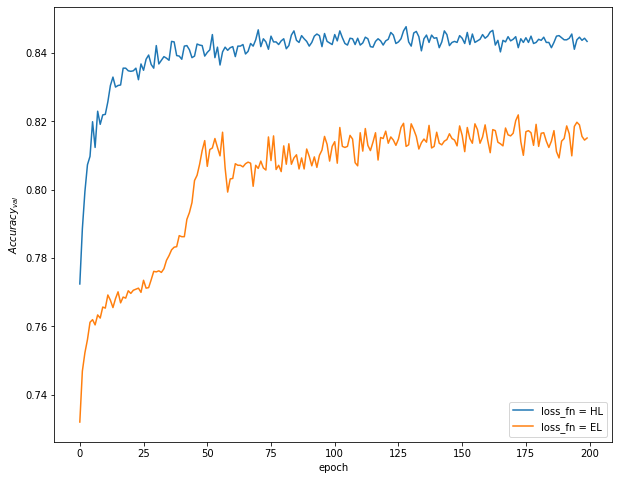

In [10]:
loss_fn = ['HL', 'EL']
l2training_losses = []
l2val_losses = []
l2train_acc = []
l2val_acc = []

for l in loss_fn:
    print()
    print(10 * '*' + ' begin L = %s ' % str(l) + 10 * '*')
    SVM, Out = svm(C=10, loss_fn=l)
    SVM.set_optimizer(SGD(lr=0.001))
    SVM.fit(X_train, y_train,
            verbose=100, epochs=200,
            validation_data=(X_val, y_val),
            batch_size=64, metric='svm_binary_accuracy',
            shuffle=True,
            peek_type='single-svm-cls')
    l2training_losses.append(SVM.training_losses)
    l2val_losses.append(SVM.valid_losses)
    l2train_acc.append(SVM.train_metrics)
    l2val_acc.append(SVM.validation_metrics)
    
for idx, l in enumerate(loss_fn):
    plt.plot(l2val_losses[idx], label='loss_fn = %s' % str(l))
plt.xlabel('epoch')
plt.ylabel('$loss_{val}$')
plt.legend()
# plt.savefig('l_val_loss.png', dpi=300)
plt.show()

for idx, l in enumerate(loss_fn):
    plt.plot(l2val_acc[idx], label='loss_fn = %s' % str(l))
plt.xlabel('epoch')
plt.ylabel('$Accuracy_{val}$')
plt.legend()
# plt.savefig('l_val_acc.png', dpi=300)
plt.show()

## Initializer comparision in Logistic Regression and SVM.

In [16]:
def svm(C=10, loss_fn='HL', init_fn='xavier_uniform_initializer'):
    Inputs = Input(input_shape=X_train.shape[1])
    Out = Linear(output_dim=1,
               regularizer=L2_Regularizer(1 / C),
                initializer=init_fn,
               activation=None)(Inputs)
    model = Model(Inputs, Out)
    # set to hinge loss
    model.set_loss(loss_fn)
    return model

def logistic_regression(init_fn='xavier_uniform_initializer'):
    Inputs = Input(input_shape=X_train.shape[1])
    Out = Linear(output_dim=1,
                 initializer=init_fn,
                 activation='sigmoid')(Inputs)
    model = Model(Inputs, Out)
    # set to hinge loss
    model.set_loss('BCE')
    return model


********** begin LR with init_fn: ones **********

epoch   100/  200, train-[loss: 0.5610 | metric: 0.8423]; valid-[loss: 0.5526 | metric: 0.8361]; 
valid-example 1/5: expect-[0], predict-[0]
valid-example 2/5: expect-[0], predict-[0]
valid-example 3/5: expect-[1], predict-[1]
valid-example 4/5: expect-[0], predict-[1]
valid-example 5/5: expect-[0], predict-[0]

epoch   200/  200, train-[loss: 0.5611 | metric: 0.8413]; valid-[loss: 0.5508 | metric: 0.8394]; 
valid-example 1/5: expect-[0], predict-[0]
valid-example 2/5: expect-[1], predict-[1]
valid-example 3/5: expect-[0], predict-[0]
valid-example 4/5: expect-[1], predict-[1]
valid-example 5/5: expect-[0], predict-[0]

********** begin LR with init_fn: zeros **********

epoch   100/  200, train-[loss: 0.3503 | metric: 0.8488]; valid-[loss: 0.3727 | metric: 0.8411]; 
valid-example 1/5: expect-[0], predict-[0]
valid-example 2/5: expect-[1], predict-[1]
valid-example 3/5: expect-[0], predict-[0]
valid-example 4/5: expect-[0], predict-[0

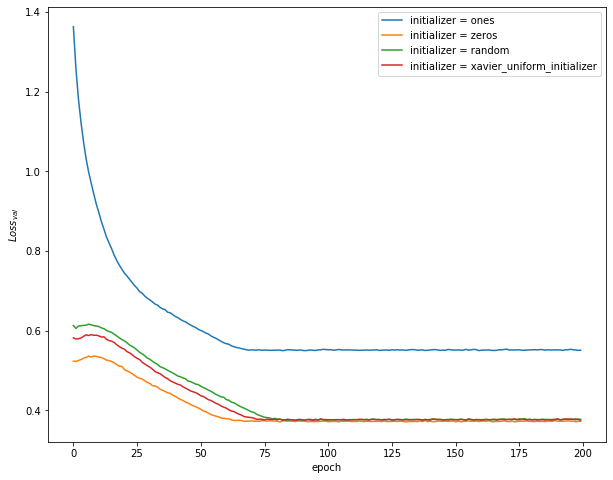

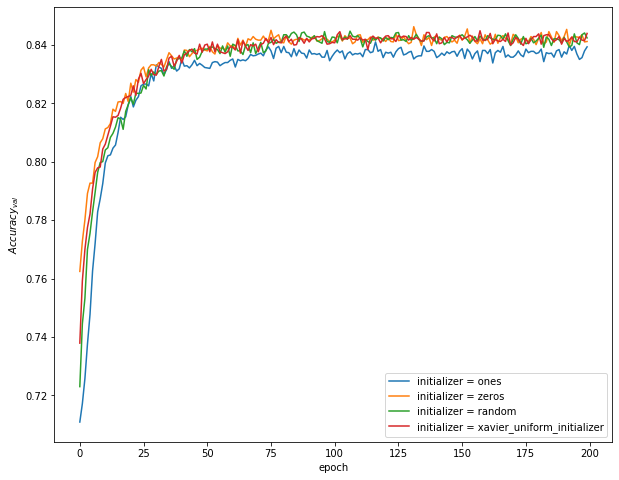


********** begin SVM with init_fn: ones **********

epoch   100/  200, train-[loss: 0.5078 | metric: 0.8500]; valid-[loss: 0.5138 | metric: 0.8464]; 
valid-example 1/5: expect-[-1], predict-[1]
valid-example 2/5: expect-[-1], predict-[-1]
valid-example 3/5: expect-[-1], predict-[-1]
valid-example 4/5: expect-[-1], predict-[-1]
valid-example 5/5: expect-[-1], predict-[-1]

epoch   200/  200, train-[loss: 0.4041 | metric: 0.8480]; valid-[loss: 0.4112 | metric: 0.8454]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[1], predict-[-1]
valid-example 3/5: expect-[1], predict-[1]
valid-example 4/5: expect-[-1], predict-[-1]
valid-example 5/5: expect-[-1], predict-[-1]

********** begin SVM with init_fn: zeros **********

epoch   100/  200, train-[loss: 0.4197 | metric: 0.8475]; valid-[loss: 0.4281 | metric: 0.8432]; 
valid-example 1/5: expect-[1], predict-[1]
valid-example 2/5: expect-[1], predict-[-1]
valid-example 3/5: expect-[-1], predict-[-1]
valid-example 4/5: e

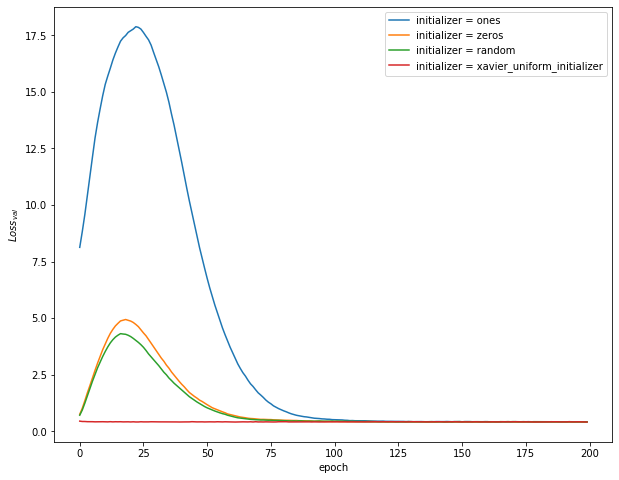

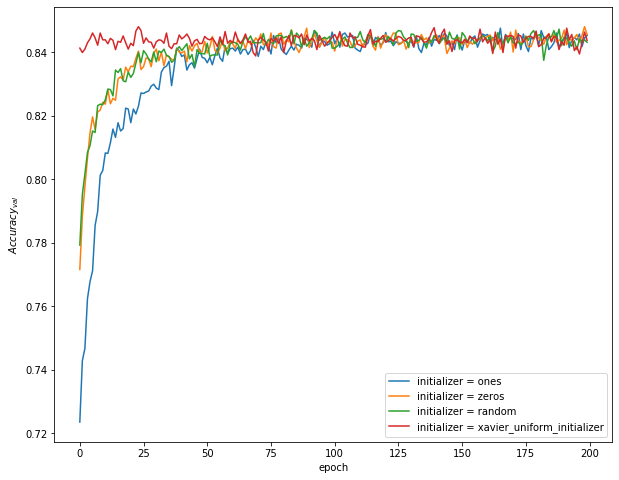

In [18]:
initializers = ['ones', 'zeros', 'random', 'xavier_uniform_initializer']
    
lr_init2val_losses = []
lr_init2val_acc = []
for init in initializers:
    print()
    print(10 * '*' + ' begin LR with init_fn: %s ' % init + 10 * '*')
    LR = logistic_regression(init_fn=init)
    LR.set_optimizer(SGD(lr=0.001))
    LR.fit(X_train, y_train_one_hot,
              verbose=100, epochs=200,
              validation_data=(X_val, y_val_one_hot),
              batch_size=64, metric='Binary_Accuracy',
              shuffle=True,
              peek_type='single-logistic-cls')
    lr_init2val_losses.append(LR.validation_losses)
    lr_init2val_acc.append(LR.validation_metrics)
    
for idx, init in enumerate(initializers):
    plt.plot(lr_init2val_losses[idx], label='initializer = %s' % str(init))
plt.xlabel('epoch')
plt.ylabel('$Loss_{val}$')
plt.legend()
plt.savefig('lr_init_val_loss.png', dpi=300)
plt.show()

for idx, init in enumerate(initializers):
    plt.plot(lr_init2val_acc[idx], label='initializer = %s' % str(init))
plt.xlabel('epoch')
plt.ylabel('$Accuracy_{val}$')
plt.legend()
plt.savefig('lr_init_val_acc.png', dpi=300)
plt.show()

svm_init2val_losses = []
svm_init2val_acc = []

for init in initializers:
    print()
    print(10 * '*' + ' begin SVM with init_fn: %s ' % init + 10 * '*')
    SVM = svm(init_fn=init)
    SVM.set_optimizer(SGD(lr=0.001))
    SVM.fit(X_train, y_train,
            verbose=100, epochs=200,
            validation_data=(X_val, y_val),
            batch_size=64, metric='svm_binary_accuracy',
            shuffle=True,
            peek_type='single-svm-cls')
    svm_init2val_losses.append(SVM.validation_losses)
    svm_init2val_acc.append(SVM.validation_metrics)
    
for idx, init in enumerate(initializers):
    plt.plot(svm_init2val_losses[idx], label='initializer = %s' % str(init))
plt.xlabel('epoch')
plt.ylabel('$Loss_{val}$')
plt.legend()
plt.savefig('svm_init_val_loss.png', dpi=300)
plt.show()

for idx, init in enumerate(initializers):
    plt.plot(svm_init2val_acc[idx], label='initializer = %s' % str(init))
plt.xlabel('epoch')
plt.ylabel('$Accuracy_{val}$')
plt.legend()
plt.savefig('svm_init_val_acc.png', dpi=300)
plt.show()

## Optimizer comparision in Logistic Regression and SVM.


**********begin LR with optimizer: <class 'simple_ml.nn.optimizer.SGD'> **********

epoch   100/  200, train-[loss: 0.3278 | metric: 0.8485]; valid-[loss: 0.3307 | metric: 0.8431]; 
valid-example 1/5: expect-[1], predict-[1]
valid-example 2/5: expect-[0], predict-[0]
valid-example 3/5: expect-[0], predict-[0]
valid-example 4/5: expect-[1], predict-[1]
valid-example 5/5: expect-[0], predict-[0]

epoch   200/  200, train-[loss: 0.3277 | metric: 0.8486]; valid-[loss: 0.3314 | metric: 0.8429]; 
valid-example 1/5: expect-[1], predict-[1]
valid-example 2/5: expect-[0], predict-[0]
valid-example 3/5: expect-[0], predict-[0]
valid-example 4/5: expect-[0], predict-[0]
valid-example 5/5: expect-[1], predict-[0]

**********begin LR with optimizer: <class 'simple_ml.nn.optimizer.Momentum'> **********

epoch   100/  200, train-[loss: 0.3517 | metric: 0.8393]; valid-[loss: 0.3470 | metric: 0.8388]; 
valid-example 1/5: expect-[0], predict-[0]
valid-example 2/5: expect-[0], predict-[0]
valid-example 

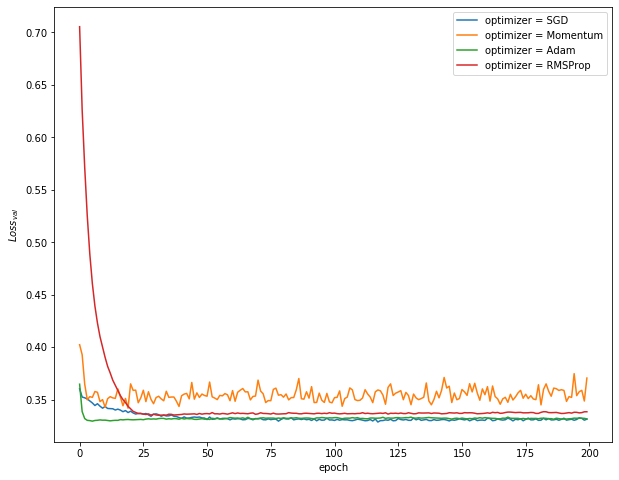

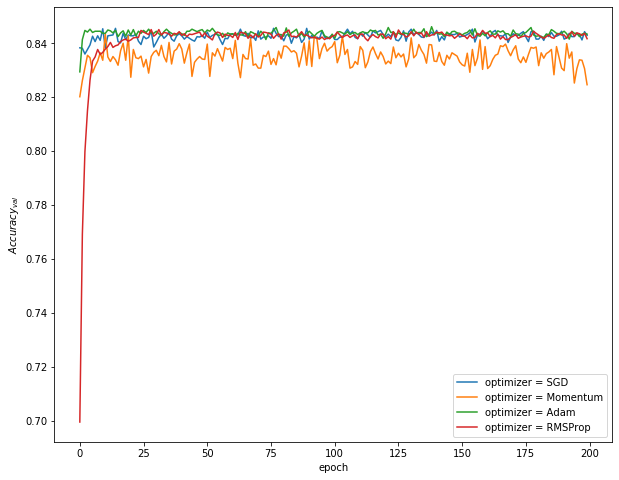

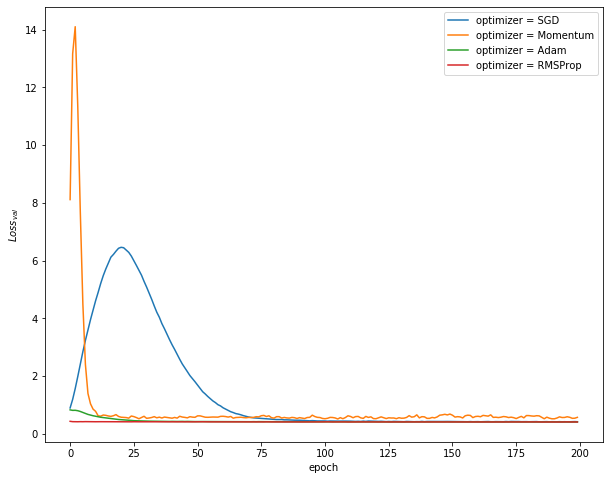

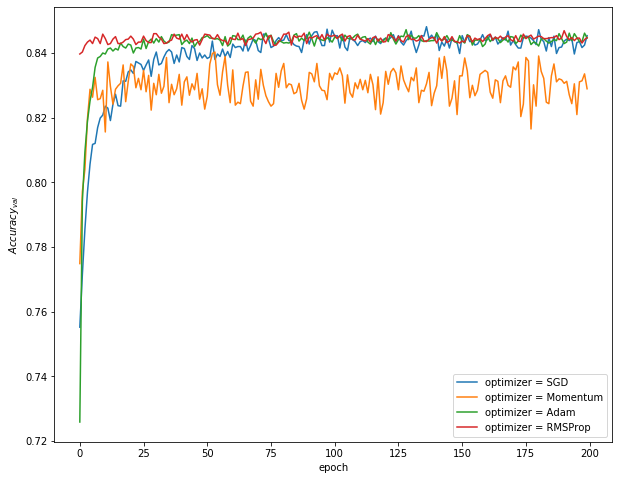

In [13]:
optims = [SGD, Momentum, Adam, RMSProp]
optim_strs = ['SGD', 'Momentum', 'Adam', 'RMSProp']

lr_optim2val_losses = []
lr_optim2val_acc = []
for optim in optims:
    print()
    print(10 * '*' + 'begin LR with optimizer: %s ' % str(optim) + 10 * '*')
    LR = logistic_regression()
    LR.set_optimizer(optim(lr=0.001))
    LR.fit(X_train, y_train_one_hot,
              verbose=100, epochs=200,
              validation_data=(X_val, y_val_one_hot),
              batch_size=64, metric='Binary_Accuracy',
              shuffle=True,
              peek_type='single-logistic-cls')
    lr_optim2val_losses.append(LR.validation_losses)
    lr_optim2val_acc.append(LR.validation_metrics)
    
for idx, optim in enumerate(optim_strs):
    plt.plot(lr_optim2val_losses[idx], label='optimizer = %s' % str(optim))
plt.xlabel('epoch')
plt.ylabel('$Loss_{val}$')
plt.legend()
# plt.savefig('lr_optim_val_loss.png', dpi=300)
plt.show()

for idx, optim in enumerate(optim_strs):
    plt.plot(lr_optim2val_acc[idx], label='optimizer = %s' % str(optim))
plt.xlabel('epoch')
plt.ylabel('$Accuracy_{val}$')
plt.legend()
# plt.savefig('lr_optim_val_acc.png', dpi=300)
plt.show()

svm_optim2val_losses = []
svm_optim2val_acc = []

for optim in optims:
    print()
    print(10 * '*' + 'begin SVM with optimizer: %s ' % optim + 10 * '*')
    SVM = svm()
    SVM.set_optimizer(optim(lr=0.001))
    SVM.fit(X_train, y_train,
            verbose=100, epochs=200,
            validation_data=(X_val, y_val),
            batch_size=64, metric='svm_binary_accuracy',
            shuffle=True,
            peek_type='single-svm-cls')
    svm_optim2val_losses.append(SVM.validation_losses)
    svm_optim2val_acc.append(SVM.validation_metrics)
    
for idx, optim in enumerate(optim_strs):
    plt.plot(svm_optim2val_losses[idx], label='optimizer = %s' % str(optim))
plt.xlabel('epoch')
plt.ylabel('$Loss_{val}$')
plt.legend()
# plt.savefig('svm_optim_val_loss.png', dpi=300)
plt.show()

for idx, optim in enumerate(optim_strs):
    plt.plot(svm_optim2val_acc[idx], label='optimizer = %s' % str(optim))
plt.xlabel('epoch')
plt.ylabel('$Accuracy_{val}$')
plt.legend()
# plt.savefig('svm_optim_val_acc.png', dpi=300)
plt.show()


## Final Performance

Now we get the final performance on validation set.

In [14]:
print(10 * '*' + ' begin best SVM ' + 10 * '*')
SVM = svm(init_fn='xavier_uniform_initializer')
SVM.set_optimizer(Adam(lr=0.001))
SVM.fit(X_train, y_train,
        verbose=100, epochs=200,
        validation_data=(X_val, y_val),
        batch_size=64, metric='svm_binary_accuracy',
        shuffle=True,
        peek_type='single-svm-cls')
pprint(SVM.best_performance())

print()
print(10 * '*' + ' begin best LR ' + 10 * '*')
LR = logistic_regression(init_fn='xavier_uniform_initializer')
LR.set_optimizer(Adam(lr=0.001))
LR.fit(X_train, y_train_one_hot,
        verbose=100, epochs=200,
        validation_data=(X_val, y_val_one_hot),
        batch_size=64, metric='Binary_Accuracy',
        shuffle=True,
        peek_type='single-logistic-cls')
pprint(LR.best_performance())

********** begin best SVM **********

epoch   100/  200, train-[loss: 0.4044 | metric: 0.8491]; valid-[loss: 0.4132 | metric: 0.8438]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[-1], predict-[-1]
valid-example 3/5: expect-[-1], predict-[-1]
valid-example 4/5: expect-[-1], predict-[-1]
valid-example 5/5: expect-[1], predict-[1]

epoch   200/  200, train-[loss: 0.4003 | metric: 0.8483]; valid-[loss: 0.4085 | metric: 0.8447]; 
valid-example 1/5: expect-[-1], predict-[-1]
valid-example 2/5: expect-[-1], predict-[-1]
valid-example 3/5: expect-[-1], predict-[-1]
valid-example 4/5: expect-[-1], predict-[-1]
valid-example 5/5: expect-[-1], predict-[-1]
{'train_set': {'best_epoch': 153,
               'best_loss': 0.4014840051365788,
               'best_metric': 0.8501669929747783},
 'val_set': {'best_epoch': 81,
             'best_loss': 0.4165882937337467,
             'best_metric': 0.8468980343980343}}

********** begin best LR **********

epoch   100/  200, t


Then we test them on test set.

In [15]:
from simple_ml.utils.metric import binary_accuracy, svm_binary_accuracy
svm_y_test_hat = SVM.forward(X_test)
print('SVM Accuracy on test set: ', svm_binary_accuracy(svm_y_test_hat, y_test) / y_test.shape[0])
lr_y_test_hat = LR.forward(X_test)
print('LR Accuracy on test set: ', binary_accuracy(lr_y_test_hat, y_test_one_hot) / y_test.shape[0])


SVM Accuracy on test set:  0.8494564215957251
LR Accuracy on test set:  0.8481051532461151
